<a href="https://colab.research.google.com/github/joshgregory42/practical_deep_learning/blob/main/ch_13_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

**Feature engineering**: Creating new transformations of the inputs data in order to make it easier to model.

In an image, a feature is a visually distinctive attribute.

Example of a convolution:



In [1]:
# Create a kernel

from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

top_edge = tensor([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]]).float()

<Axes: >

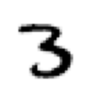

In [2]:
# Grab image

path = untar_data(URLs.MNIST_SAMPLE)

im3 = Image.open(path/'train'/'3'/'12.png')

show_image(im3)

Take the top 3x3-pixel square of our image and multiply each of those values by every value in our kernel, then add them:

In [3]:
im3_t = tensor(im3)

im3_t[0:3, 0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [4]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

Pick a couple of interesting spots:

In [5]:
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


Top edge at cell 5,8. Repeat our calculation there:

In [6]:
(im3_t[4:7, 6:9] * top_edge).sum()

tensor(762.)

Try the right edge at cell 8, 18:

In [7]:
(im3_t[7:10, 17:20] * top_edge).sum()

tensor(-29.)

Better idea is to have a row of 1s at the top and -1s at the bottom would detect horizontal edges that go from dark to light.

Putting the 1s and -1s in columns vs rows would give us filters that detect vertical edges.

Create a function to do this for one location and make sure it matches our result from earlier:

In [8]:
def apply_kernel(row, col, kernel):
  return (im3_t[row-1:row+2, col-1:col+2] * kernel).sum()

In [9]:
apply_kernel(5, 7, top_edge)

tensor(762.)

Issue here is that we can't apply this to a corner (like (0, 0)) since there isn't a complete 3x3 square there.

### Mapping a Convolution Kernel

Use a nested list comprehension to get a grid of coordinates:

In [10]:
[[(i, j) for j in range(1, 5)] for i in range(1, 5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

Apply our kernel over a coordinate grid:

<Axes: >

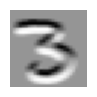

In [11]:
rng = range(1, 27)

top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])

show_image(top_edge3)

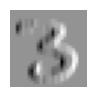

In [12]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

Notice that the top edges are black and the bottom ones are white, which is what we want.

### Convolutions in PyTorch

PyTorch can do convolutions faster than stock Python. Function is called `F.conv2d` (remember that `F` is a fastai import from `torch.nn.functional`, as recommended by PyTorch).

Has the following parameters:

* input: input temsor of shape `(minibatch, in_channels, iH, iW)`
* weight: filters of shape `(out_channels, in_channels, kH, kW)`

where `iH, iW` are the height and width of the image and `kH, kW` are the height and width of our kernel.

Note that for this function PyTorch is expecting rank-4 tensors for both of these arguments, mainly because PyTorch can apply a convolution to multiple images at the same time, and can also apply multiple kernels at the same time.

Create diagonal-edge kernels too, then stack all four of our edge kernels into a single tensor:

In [13]:
diag1_edge = tensor([[0, -1, 1],
                     [-1, 1, 0],
                     [1, 0, 0]]).float()

diag2_edge = tensor([[1, -1, 0],
                     [0, 1, -1],
                     [0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

Create a `DataLoader` and sample a mini-batch using the data block API:

In [14]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)

xb, yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

fastai puts data onto the GPU by default when using data blocks. Can move it to the CPU:

In [15]:
xb, yb = to_cpu(xb), to_cpu(yb)

Here, one batch has 64 images, each of 1 channel, with 28x28 pixels. `F.conv2d` can handle multichannel (i.e. color) images too.

*Channel*: A single basic color in an image. For color images, there are three channels: red, greed, and blue.

PyTorch represents an image as a rank-3 tensor, with dimensions `[channels, rows, columns]`.

Kernels passed to `F.conv2d` need to be rank-4 tensors: `[channels_in, features_out, rows, columns]`.

Need to tell PyTorch that the number of input channels in the kernel is one. To do that, can inser an axis of size one (aka a unit axis) in the first location. To insert a unit axis into a tensor, can use the `unsqueeze` method.

In [16]:
edge_kernels.shape, edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [17]:
edge_kernels = edge_kernels.unsqueeze(1)

In [18]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

Gave 64 images in the mini-batch, 4 kernels, and 26x26 edge maps.

Get the same result as when we did this manually:

<Axes: >

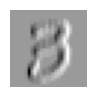

In [19]:
show_image(batch_features[0, 0])

### Strides and Padding

Padding allows us to ensure that the output activation map is the same size as the original image (i.e. not losing any pixels after the convolution), which can make things a lot simpler when we construct our architectures.

Padding is what we do to the pixels on the corners of an image.

A couple other notes about CNNs:

* A convolution can be represented as a special kind of matrix multiplication with two special properties:

  * The bias term is the same for each section of the image.
  * Some of the weights are equal, and while they are trainable, they must remain equal. These are called *shared weights*.

### Our First Convolutional Neural Network

There's no reason to think that some specific edge filters are useful kernels. Best thing to do would be to learn the values of the kernels.

This can be done using SGD. Essentially the model will learn the features that are useful for classification.

A CNN is created when we use convolutions instead of (or in addition to) regular linear layers.

### Creating the CNN

In [20]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

View model's definition:

In [21]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

Want to create a similar architecture to this, but using convolutional layers instead of linear ones.

`nn.Conv2d` is the module equivalent of `F.conv2d`. It creates the weight matrix automatically for us:

In [22]:
broken_cnn = sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1)
)

In [23]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

Can't use this to do classification since we need a single output activation per image.

Can deal with this by using a bunch of stride-2 convolutions so that the final layer is size 1. In other words, after one stride-2 convolution the size will be 14x14, then 7x7, 4x4, 2x2, and then 1.

Let's try that:

In [24]:
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

> jargon: channels and features: These two terms are largely used interchangeably, and refer to the size of the second axis of a weight matrix, which is, the number of activations per grid cell after a convolution. _Features_ is never used to refer to the input data, but _channels_ can refer to either the input data (generally channels are colors) or activations inside the network.

Building a simple CNN:

In [25]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

> j: I like to add comments like the ones here after each convolution to show how large the activation map will be after each layer. These comments assume that the input size is 28*28

Now network outputs two activations, which map to the two levels in our labels:

In [26]:
simple_cnn(xb).shape

torch.Size([64, 2])

Create our `Learner`:

In [27]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [28]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

Train this, but since it's deeper than our other ones, we'll use a lower learning rate and more epochs:

In [29]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.061286,0.035448,0.989205,00:27
1,0.018352,0.025713,0.991659,00:29


### Understanding Convolution Arithmetic

Have an input of size `64x1x28x28`. Axes are `batch, channel, height, width`. Abbreviated as `NCHW`, where `N` is the batch size. Tensorflow uses the `NHWC` axis order. First layer is:

In [30]:
m = learn.model[0]

m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

Have 1 input channel, 4 output channels, and a 3x3 kernel. Check the weights of the first convolution:

In [31]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

Summary says we have 40 parameters, but here we only have 36. The other 4 are in the bias array:

In [32]:
m[0].bias.shape

torch.Size([4])

## Color Images

A color picture is a rank-3 tensor. One for each channel (i.e. RGB). To apply a convolution to a color picture, we need a kernel tensor with a size that matches the first axis.

At each location, the corresponding parts of the kernel and the image patch are multiplied together.

These are then all added together, to produce a single number, for each grid location, for each output feature.

## Improving Training Stability

Good at recognizing 3s from 7s. Now let's recognize all 10 digits.

In [35]:
path = untar_data(URLs.MNIST)

In [37]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

Data is in two folders named `testing` and `training`, so we need to pass that to `GrandparentSplitter` since it defaults to `train` and `valid`:

In [39]:
def get_dls(bs=64):
  return DataBlock(
      blocks = (ImageBlock(cls=PILImageBW), CategoryBlock),
      get_items = get_image_files,
      splitter = GrandparentSplitter('training', 'testing'),
      get_y = parent_label,
      batch_tfms = Normalize()
  ).dataloaders(path, bs=bs)

dls = get_dls()

Always want to look at data before we use it:

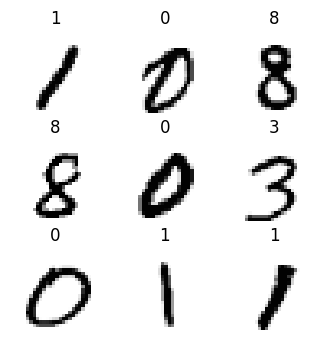

In [40]:
dls.show_batch(max_n=9, figsize=(4, 4))

Now let's train a simple model on these data

### A Simple Baseline

Earlier we built a model based on a `conv` function like this:

In [41]:
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

Start with a basic CNN as a baseline, but use more activations. Since we'll have more numbers to differentiate, we'll probably need to learn more filters.

Need to use a larger kernel in the first layer:

In [43]:
def simple_cnn():
  return sequential(
      conv(1, 8, ks=5),         # 14x14
      conv(8, 16),              # 7x7
      conv(16, 32),             # 4x4
      conv(32, 64),             # 2x2
      conv(64, 10, act=False),  # 1x1
      Flatten(),
  )

Can look inside our models while they're training to find ways to train them better. Can do this using the `ActivationStats` callback, which records the mean, standard deviation, and histogram of activations of every trainable layer.

In [44]:
from fastai.callback.hook import *

Want to train quickly, so we need a high learning rate. Let's try 0.06:

In [47]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [48]:
learn = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.308434,2.309538,0.098000,02:06


That trained like crap. Let's see if we can figure out why.

Callbacks passed to `Learner` are available automatically. So `ActivationStats` can be accessed through `activation_stats`.

`ActivationStats` also lets us plot them using `plot_layer_stats(idx)`:

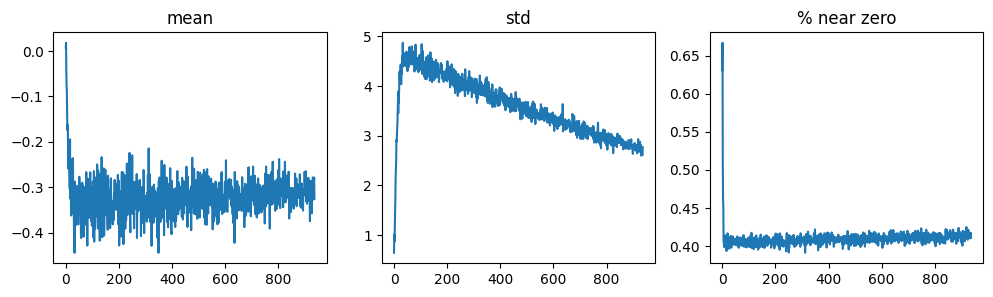

In [49]:
learn.activation_stats.plot_layer_stats(0)

Want our model to have a consistent and smooth mean and std of layer activations during training.

Activations near zero aren't good because that means we have computation in the model that's doing nothing at all. Zeros in one layer generally carries over to the next layer, which makes more zeros.

Penultimate layer of our network:

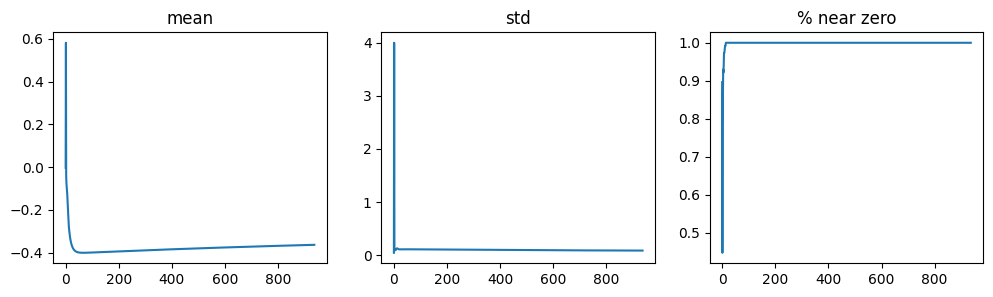

In [50]:
learn.activation_stats.plot_layer_stats(-2)

Problems are much worse towards the end of the network as instability and zero activations compound over layers. Can do a few things to make training more stable:

### Increase Batch Size

Larger batches have gradients that are more accurate since they're calculated from more data.

Issue is that a larger batch size means fewer batches per epoch, which means less opportunities for the model to update its weights.

Try a batch size of 512 and see what that does:

In [51]:
dls = get_dls(512)

In [52]:
learn = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.303916,2.303833,0.101000,01:27


Check penultimate layer again:

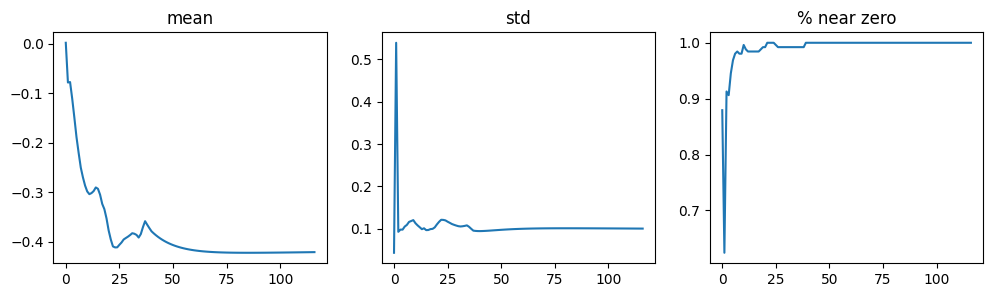

In [53]:
learn.activation_stats.plot_layer_stats(-2)

Most of the activations are still near zero. Let's try some other techniques to improve the training stability.

### 1cycle Training

Our initial weights are not well suited to the task we're trying to solve. Therefore, it is dangerous to begin training with a high learning rate: we may very well make the training diverge instantly, as we've seen. We probably don't want to end training with a high learning rate either, so that we don't skip over a minimum. But we want to train at a high learning rate for the rest of the training period, because we'll be able to train more quickly that way. Therefore, we should change the learning rate during training, from low, to high, and then back to low again.

1cycle training allows us to use a much higher maximum learning rate than other types of training, which gives two benefits:

- By training with higher learning rates, we train faster—a phenomenon Smith named *super-convergence*.
- By training with higher learning rates, we overfit less because we skip over the sharp local minima to end up in a smoother (and therefore more generalizable) part of the loss.

Use 1cycle training in fastai by calling `fit_one_cycle`:

In [54]:
def fit(epochs=1, lr=0.06):
  learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                  metrics=accuracy, cbs=ActivationStats(with_hist=True))
  learn.fit_one_cycle(epochs, lr)
  return learn

In [55]:
learn = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.201311,0.083485,0.973500,01:31


Finally making some progress which is good.

Can view the learning rate and momentum throughout training by calling `plot_sched` on `learn.recorder`.

`learn.recorder` records everything that happens during training, including losses, metrics, and hyperparameters like learning rate and momentum:

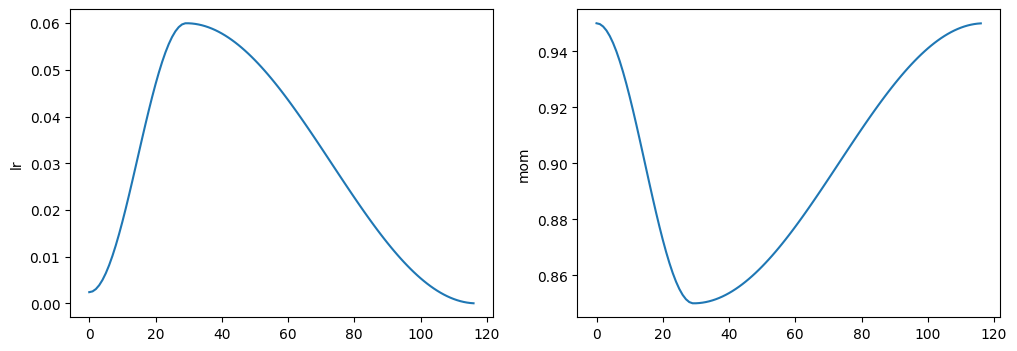

In [56]:
learn.recorder.plot_sched()

`fit_one_cycle` provides the following parameters you can adjust:

- `lr_max`:: The highest learning rate that will be used (this can also be a list of learning rates for each layer group, or a Python `slice` object containing the first and last layer group learning rates)
- `div`:: How much to divide `lr_max` by to get the starting learning rate
- `div_final`::  How much to divide `lr_max` by to get the ending learning rate
- `pct_start`:: What percentage of the batches to use for the warmup
- `moms`:: A tuple `(mom1,mom2,mom3)` where *`mom1`* is the initial momentum, *`mom2`* is the minimum momentum, and *`mom3`* is the final momentum

Let's take a look at our layer stats again:

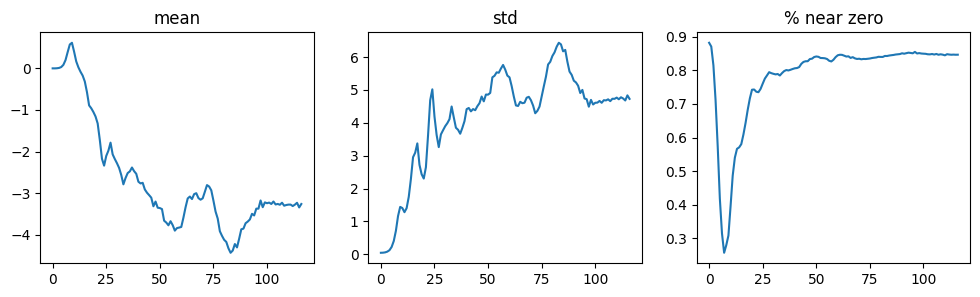

In [57]:
learn.activation_stats.plot_layer_stats(-2)

Percentage of near-zero weights is getting better, but it's still pretty high.

Can see even more about what's going on during training with `color_dim` and passing it a layer index:

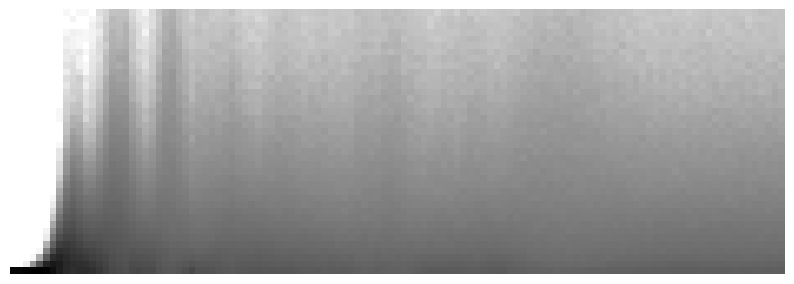

In [58]:
learn.activation_stats.color_dim(-2)

This shows a classiv picture of "bad training". Start with nearly all activations at zero on the far left. Then the number of nonzero activations increases exponentially over the first batch, then collapses. It almost looks like training restarts from scratch. Then we see the activations increase again, and collapse again. After repeating this a few times, eventually we see a spread of activations throughout the range.

It's much better if training can be smooth from the start. The cycles of exponential increase and then collapse tend to result in a lot of near-zero activations, resulting in slow training and poor final results. One way to solve this problem is to use batch normalization.

### Batch Normalization

Need to fix the initial large percentage of near-zero activations, and then try to maintain a good distribution of activations throughout training.

Solution was described in a paper:

["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167). In the abstract, they describe just the problem that we've seen:

> : Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their solution, they say is:

> : Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

The paper caused great excitement as soon as it was released, because it included the chart in <<batchnorm>>, which clearly demonstrated that batch normalization could train a model that was even more accurate than the current state of the art (the *Inception* architecture) and around 5x faster.

Batch normalization (aka *batchnorm*) takes an average of the mean and standard deviations of the activations of a layer and using those to normalize the activations.

Issue is that the network might want some activations to be really high. Solution is to add two learnable parameters, `gamma` and `beta` such that after normalizing the activations to get some new activation vector `y`, a batchnorm layer returns `gamma*y + beta`.

So our activations can have any mean or variance, independent from the mean and std. of the results of the previous layer. These stats are learned separately, making training easier.

During training, use the mean and std. of the batch to normalize the data, while during validation we instead use a running mean of the statistics calculated during training.



Add a batchnorm layer to `conv`:

In [59]:
def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  if act: layers.append(nn.ReLU())
  layers.append(nn.BatchNorm2d(nf))
  return nn.Sequential(*layers)


Fir our model:

In [60]:
learn = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.131327,0.056995,0.985600,01:51


Look at `color_dim`:

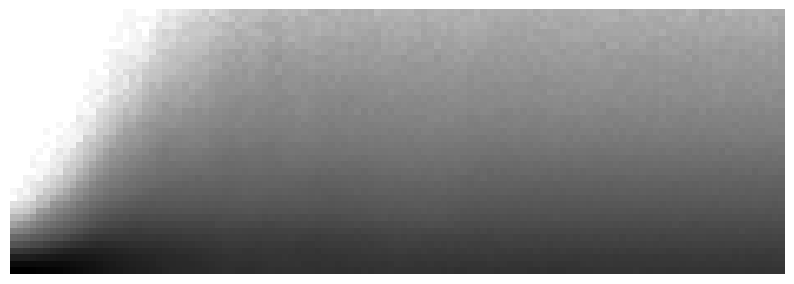

In [61]:
learn.activation_stats.color_dim(-4)

Batchnorm worked really freaking well. So well that it's used in most modern neaural networks.

Models that contain batchnorm tend to generalize better than models that don't contain them. Some people think the reason why is due to the extra randomness the batchnorm process adds to the training process.

Let's turn things up and train for a little while and increase the learning rate (since the paper said we could):

In [62]:
learn = fit(5, lr=0.1)

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.187005,0.256744,0.917600,01:32
1,0.080883,0.064979,0.980000,01:31
2,0.050706,0.042744,0.987700,01:35
3,0.031638,0.026179,0.991300,01:33
4,0.015895,0.022947,0.992000,01:32
